# Introduction

 This project employs a comprehensive image classification pipeline, including data preprocessing, augmentation, and model training/evaluation. 



Images are loaded, resized, normalized, and converted to a suitable format. Stratified data splitting ensures balanced class distribution. Data augmentation techniques enhance model robustness. Model training incorporates early stopping to prevent overfitting. Performance is assessed using classification reports, confusion matrices, and visual comparisons. 

## Dataset Overview

**Dataset Structure:** 
* **Image Folders:** Images are organized into folders based on road anomaly types: pothole, garbage, and fallen tree.
* **CSV Files:** Separate CSV files for training and testing sets are provided. Each CSV contains two columns: 'image_path' and 'label'.
    * **image_path:** The relative path to the image file within the dataset.
    * **label:** The corresponding road anomaly type (pothole, garbage, or fallen tree).

**Data Splitting:** 
The dataset is divided into training and testing sets. The training set is used to train the model, while the testing set is used to evaluate its performance. The split is designed to be representative of the overall dataset, ensuring a balanced distribution of road anomaly types in both sets. 


# Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import img_to_array, load_img,ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

import warnings

warnings.filterwarnings('ignore', category=UserWarning, message='.*')

# Load Data From Directories
representation of folder in my system is given below

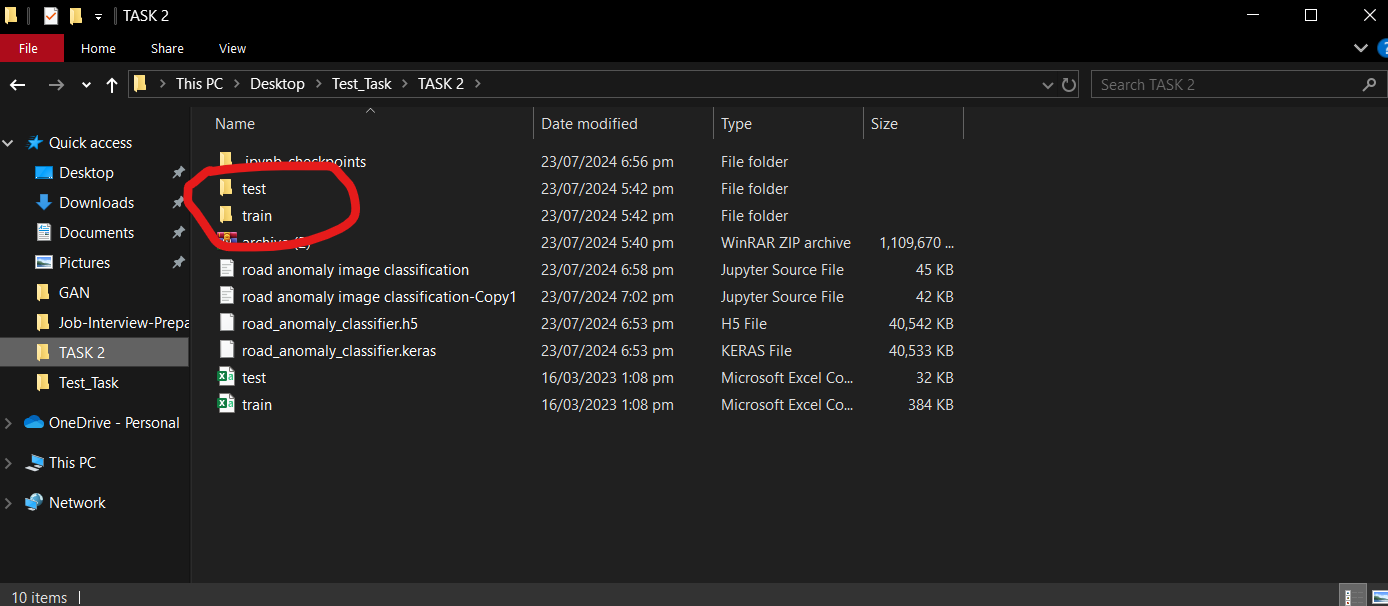

In [3]:
# Load data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Function to load images from paths
def load_images(image_paths):
    images = []
    for img_path in image_paths:
        img = load_img(img_path, target_size=(150, 150))
        img = img_to_array(img)
        images.append(img)
    return np.array(images)

In [4]:
# Base directory for images
base_train_dir = 'train/'
base_test_dir = 'test/'

# Function to load images from paths
def load_images(image_paths, base_dir):
    images = []
    for img_path in image_paths:
        full_path = os.path.join(base_dir, img_path)
        img = load_img(full_path, target_size=(150, 150))
        img = img_to_array(img)
        images.append(img)
    return np.array(images)

# Load training and testing images
train_images = load_images(train_df['img_path'].values, base_train_dir)
train_labels = train_df['label'].values

test_images = load_images(test_df['img_path'].values, base_test_dir)
test_labels = test_df['label'].values

# Applying Normalization to Images

In [5]:
# Normalize images
train_images = train_images / 255.0
test_images = test_images / 255.0

# One-hot encode labels
num_classes = len(np.unique(train_labels))
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

# Doing Equal Train/Test Split 

In [6]:
# Stratified split
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42, stratify=train_labels.argmax(axis=1))

# Applying Augmentation for better generalization

In [7]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define Model Architecture

In [8]:
# CNN model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

### Loss Function: categorical_crossentropy - Suitable for multi-class classification.
### Optimizer: Adam optimizer with a learning rate of 1e-3.
### Metrics: Accuracy is used to evaluate the performance during training and validation.

In [9]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-3),  # Adjust learning rate
              metrics=['accuracy'])

# Model Training

In [10]:
# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with data augmentation
history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=32),
    epochs=5,
    validation_data=(val_images, val_labels),
    callbacks=[early_stopping]
)

Epoch 1/5


505/505 [==============================] - 247s 485ms/step - loss: 0.4622 - accuracy: 0.8271 - val_loss: 0.2803 - val_accuracy: 0.8912
Epoch 2/5
505/505 [==============================] - 224s 443ms/step - loss: 0.2606 - accuracy: 0.9081 - val_loss: 0.1829 - val_accuracy: 0.9343
Epoch 3/5
505/505 [==============================] - 223s 441ms/step - loss: 0.1920 - accuracy: 0.9318 - val_loss: 0.1386 - val_accuracy: 0.9561
Epoch 4/5
505/505 [==============================] - 223s 441ms/step - loss: 0.1706 - accuracy: 0.9388 - val_loss: 0.0994 - val_accuracy: 0.9710
Epoch 5/5
505/505 [==============================] - 222s 440ms/step - loss: 0.1499 - accuracy: 0.9498 - val_loss: 0.1030 - val_accuracy: 0.9623


# Model Evaluations

In [11]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc}')

56/56 [==============================] - 5s 91ms/step - loss: 0.1858 - accuracy: 0.9410
Test accuracy: 0.9410096406936646


In [12]:
# Predict labels for test data
test_predictions = model.predict(test_images)
test_predictions_classes = np.argmax(test_predictions, axis=1)
test_labels_classes = np.argmax(test_labels, axis=1)

# Generate classification report and confusion matrix
report = classification_report(test_labels_classes, test_predictions_classes, target_names=[str(i) for i in range(num_classes)])
conf_matrix = confusion_matrix(test_labels_classes, test_predictions_classes)

print("Classification Report:\n", report)

56/56 [==============================] - 5s 86ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.88      0.91       100
           1       0.95      0.98      0.97       467
           2       0.89      0.90      0.90       305
           3       0.95      0.94      0.95       891

    accuracy                           0.94      1763
   macro avg       0.94      0.93      0.93      1763
weighted avg       0.94      0.94      0.94      1763



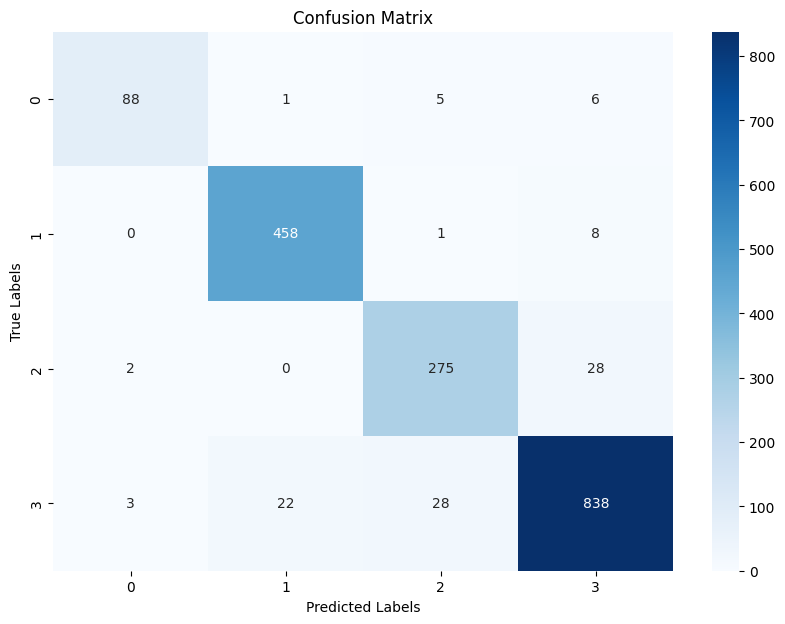

In [13]:
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(num_classes)], yticklabels=[str(i) for i in range(num_classes)])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Loss Accuracy Graph

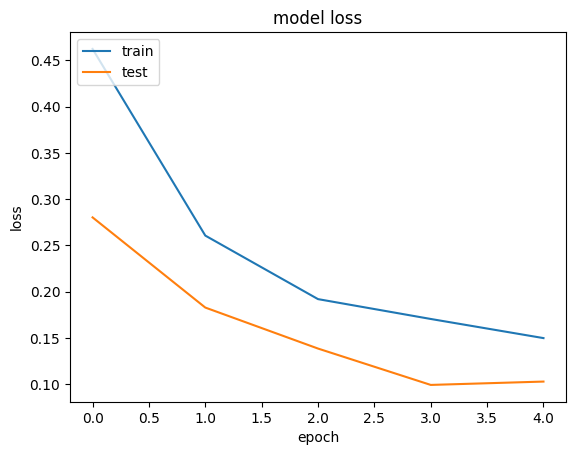

In [14]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

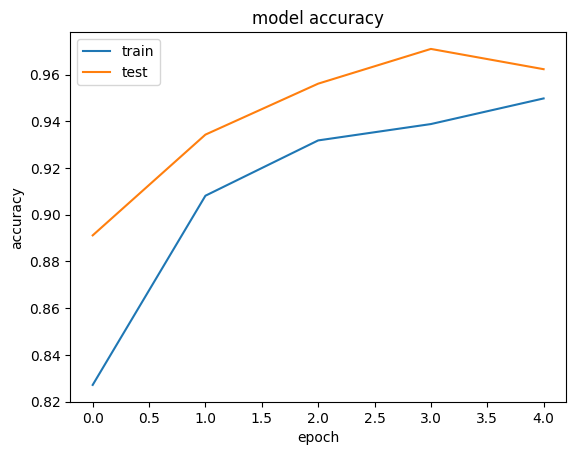

In [15]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Saving Model for Future use

In [16]:
# Save the model
model.save('road_anomaly_classifier.keras')